# Variational Autoencoder
Based on variational inference

$$P(Z|X) = \frac{P(Z,X)}{P(X)}$$

## Some basic information theory
### Information 
$I = -log(P(x))$
* Measures the factor of uncertainty removed when x is known
* 1 bit can be thought of as information that reduces uncertainty
    by a factor of 2
E.g. Let's say there is 50% chance of weather being sunny and 
50% chance of rain tomorrow. When the weather station tells us it is going to be sunny, they have given us 1 bit of information.

> Uncertainty reduction is the inverse of the event's probability

E.g. If the weather probabilities are sunny 75% and rain 25%,
finding out that it is going to be rainy will reduce our 
uncertainty by $1/0.25 = 4$. This corresponds to $log_2(4) = 2$ bits of information $log_2(\frac{1}{0.25}) = -log_2(0.25)$

### Entropy 
$H = \sum_x-log(P(x)) * P(x))$  
* Can be thought of as average amount of information relayed by a certain distribution
E.g in the above case, the weather station on average transmits
$$ H = 0.75 \times -log(0.75) + 0.25 \times (-log(0.25)) 
  = 0.81$$ bits of useful information

### Cross-entropy
$$H(P,Q) = \sum_x P(x)(-log(Q(x))$$

E.g Lets say we use 2 bits to encode our weather prediction
this can be thought of as us predicting the weather to have
a 25% chance of either being sunny or rainy
The average number of actual bits sent is
$H = 0.75 \times 2 + 0.25 \times 2 = 2 $bits. If using different number of bits for the different predictions $H = 0.75 \times 2 + 0.25 \times 3 = 2.25 $bits 

Based on the entropy and cross-entropy, we can see that our _predicted_ probability distribution Q(x) differs from the _actual_ probability distribution P(x) by 
$KL(P||Q) = 2.25 - 0.81 = 1.54 $bits  
If predictions are perfect i.e. Q(x) = P(x), then H(P,Q) = H(P)  
Therefore, $H(P,Q) = H(P) + KL(P||Q)$  
$KL(P||Q)$ means KL-divergence of Q w.r.t P

\begin{align}
KL(P||Q) &= H(P,Q) - H(P)\\
         &= \sum_x P(x)(-log(Q(x)) -  \sum_xP(x)(-log(P(x))\\
         &= \sum_{x} P(x)(-log(Q(x) - (-log(P(x)))\\
         &= \sum_x P(x)(log(P(x)) - log(Q(x)))\\
         &= \sum_x P(x)(log(\frac{P(x)}{Q(x)}))\\
\end{align}
#### Some properties of KL-divergence
1. $KL(P||Q)$ is alwaysgreater than or equal to 0
2. $KL(P||Q)$ is not the same as $KL(Q||P)$


## Variational Bayes

$$P(Z|X) = \frac{P(Z,X)}{P(X)} = \frac{P(X|Z)P(Z)}{P(X)}$$

We don't know P(X). If we were to compute it,
$P(X) = \int{P(X|Z)P(Z)dZ}$
* Intractable in many cases
* If distributions are high dimensional, integral is multi-integral

Thus, we can try to approximate the distribution. One method to approximate is Monte Carlo method (Gibbs sampling and other sampling methods) which is unbiased with high variance.

Another is variational inference which has low variance but is biased

1. Approximate P(Z|X) with Q(Z) that is tractable e.g. Gaussian
2. Play with the parameters of Q(Z) in a way that it gets close enough to P(Z|X) i.e. minimize $KL(Q(Z)||P(Z|X))$

This brings us to the following objective of minimizing 


\begin{align}
KL(Q(Z)||P(Z|X)) &= \sum_z Q(Z)log(\frac{Q(Z)}{P(Z|X)})\\
                 &= - \sum_zQ(Z) log(\frac{P(Z|X)}{Q(Z)})\\
                 &= - \sum_z Q(Z) log(\frac{P(X,Z)}{P(X) Q(Z)})\\
                 &= - \sum_z Q(Z) (log(\frac{P(X,Z)}{Q(Z)}) - log(P(X)))\\
                 &= - \sum_z Q(Z) log(\frac{P(X,Z)}{Q(Z)}) + log(P(X))\\
\end{align}
\begin{align}
\therefore log(P(X))    &= KL(Q(Z)||P(Z|X)) + \sum_z Q(Z)log(\frac{P(X,Z)}{Q(Z)})\\
                 &= KL(Q(Z)||P(Z|X)) + L\\
\end{align}


As $log(P(X))$ is a constant, to minimize $KL(Q(Z)||P(Z|X))$,
we just need to maximize $L$.

$$\because KL(Q(Z)||P(Z|X)) \geq 0$$,  
$$L \leq P(X)$$ Thus, L is a lower bound of P(X).

\begin{align}
L &= \sum_z Q(Z) log(\frac{P(X,Z)}{Q(Z)})\\
  &= \sum_z Q(Z) log(\frac{P(X|Z)P(Z)}{Q(Z)})\\
  &= \sum_z Q(Z)(log(P(X|Z)) + log(\frac{P(Z)}{Q(Z)}))\\
  &= \sum_z Q(Z) log(P(X|Z))) + \sum_z Q(Z) log(\frac{P(Z)}{Q(Z)})\\
\end{align}

$$\sum_z Q(Z) log(P(X|Z))) = E_{Q(Z)}P(X|Z)$$
$$\sum_z Q(Z) log(\frac{P(Z)}{Q(Z)}) = -KL(Q(Z)||P(Z))$$
Representing L as an autoencoder

X --> Q(Z|X) --> Z --> P(X|Z) --> X'

$E_{Q(Z)}P(X|Z)$ term acts as reconstruction error.
$P(X|Z)$ is deterministic meaning one input will get the same output all the time. Thus, it can be considered $P(X|X')$.

If $P(X|X')$ is gaussian
$$P(X|X') = e^{-|X - X'|^2}$$
$$log(P(X|X')) = -|X - X'|^2$$ --> L2 loss

If Bernoulli distribution, will be similar to cross-entropy

So far the network is all deterministic
> To make it probabilistic, 
    encoder should not parametrize Z but instead the parametrize
    the distribution that generates Z i.e. $\mu$ and $\sigma$



In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import traceback

/home/naren/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('../CapsNet/train.csv')
labels = np.asarray(df.label).reshape(42000,1)
train_x = np.asarray(df[df.columns[1:]]).reshape(42000,28*28)/255.0

In [9]:
############################ SIMPLE MODEL ###############################################
mu_data, sigma_data = 3., 1.75
mu_z, sigma_z = 0., 1.
alpha = 0.2
np.random.seed(0)
#data_distribution = np.random.normal(mu_data, sigma_data, (40000, 10))
#data_distribution /= np.max(data_distribution,axis=1).reshape(40000,1)

latent_distribution = np.random.normal(mu_z, sigma_z, (42000, 16))
tf.Graph().as_default()
X = tf.placeholder(tf.float32, (None, 784))
with tf.name_scope('encoder'):
    en_1 = tf.layers.BatchNormalization()(X)
    en_1 = tf.layers.Dense(512)(en_1)
    en_1 = tf.maximum(en_1, alpha*en_1)
  #  en_2 = tf.layers.Dense(256)(en_1)
  #  en_2 = tf.maximum(en_2, alpha*en_2)
  #  en_3 = tf.layers.Dense(128)(en_2)
  #  en_3 = tf.maximum(en_3, alpha*en_3)
  #  encoded = tf.layers.Dense(32)(en_3)
    #encoded = tf.maximum(encoded, alpha*encoded)
    mean = tf.layers.Dense(16)(en_1)
    log_stdev = tf.layers.Dense(16)(en_1)
#log_stdev = encoded[:,0:16]
#mean = encoded[:,16:32]
latent_samples = tf.placeholder(tf.float32, (None,16))
Z = latent_samples * tf.exp(log_stdev) + mean
with tf.name_scope('decoder'):
    de_3 = tf.layers.BatchNormalization()(Z)
 #   de_1 = tf.layers.Dense(128)(Z)
 #   de_1 = tf.maximum(de_1, alpha*de_1)
 #   de_2 = tf.layers.Dense(256)(de_1)
 #   de_2 = tf.maximum(de_2, alpha*de_2)
    de_3 = tf.layers.Dense(512)(de_3)
    de_3 = tf.maximum(de_3, alpha*de_3)
    output = tf.layers.Dense(784,activation=tf.nn.sigmoid)(de_3)
scale = 1.
beta = 1.3
recon_loss = tf.reduce_sum((tf.square(X - output)),axis=1)#tf.keras.losses.binary_crossentropy(X,output) #
kl_loss = - 0.5 * tf.reduce_sum(1 + log_stdev - tf.square(mean) - tf.square(tf.exp(log_stdev)), axis=1)
loss = tf.reduce_mean(scale*recon_loss + beta*kl_loss)
adam = tf.train.AdamOptimizer()
train = adam.minimize(loss)

In [10]:
epochs = 100
bs = 100
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess,'./checkpoints/simple.ckpt')
    try:
        for i in range(epochs):
            print('Ep: ' + str(i))
            #plt.imshow(sess.run(output,{X:train_x[0:1],latent_samples:latent_distribution[0:1]})[0].reshape((28,28)))
            for b in range(420):
            #batch = train_x[b*batch_s:]
                sess.run(train,{X:train_x[b*bs:b*bs+1],latent_samples:latent_distribution[b*bs:b*bs+1]})
                if b % 1 == 0:
                    saver.save(sess,'./checkpoints/simple.ckpt')
                    print("Loss: " + str(sess.run(loss,{X:train_x[b*bs:b*bs+1],latent_samples:latent_distribution[b*bs:b*bs+1]})))
    except Exception as e:
        print(e)
    finally:
        saver.save(sess,'./checkpoints/simple.ckpt')
        print('Model saved')
        
    

Ep: 0
Loss: 177.10197
Loss: 174.9884
Loss: 177.77644
Loss: 169.6912
Loss: 175.69656
Loss: 178.36407
Loss: 163.31448
Loss: 151.23634
Loss: 151.80762
Loss: 150.82819
Loss: 143.25818
Loss: 125.77664
Loss: 131.02132
Loss: 112.56998
Loss: 115.341194
Loss: 115.09156
Loss: 99.46825
Loss: 99.11499
Loss: 110.53991
Loss: 110.3375
Loss: 131.6341
Loss: 83.71629
Loss: 69.2778
Loss: 80.45781
Loss: 82.45722
Loss: 64.87318
Loss: 74.39568
Loss: 75.88929
Loss: 73.3332
Loss: 86.724915
Loss: 63.288235
Loss: 70.689575
Loss: 47.110123
Loss: 87.62468
Loss: 43.731014
Loss: 66.339005
Loss: 78.8536
Loss: 68.65915
Loss: 44.76635
Loss: 52.96234
Loss: 70.8085
Loss: 60.89643
Loss: 63.854668
Loss: 75.205765
Loss: 54.293983
Loss: 56.41359
Loss: 56.60161
Loss: 52.702545
Loss: 53.979946
Loss: 117.09386
Loss: 48.657963
Loss: 72.29598
Loss: 69.71948
Loss: 54.099236
Loss: 60.36777
Loss: 41.613586
Loss: 62.134735
Loss: 78.0742
Loss: 85.55058
Loss: 80.83485
Loss: 28.817757
Loss: 65.26507
Loss: 69.832985
Loss: 62.45613
Loss:

Loss: 26.877909
Loss: 42.509598
Loss: 47.806465
Loss: 38.335705
Loss: 31.61668
Loss: 44.49321
Loss: 23.760427
Loss: 37.838116
Loss: 39.629642
Loss: 65.56656
Loss: 50.0655
Loss: 43.745453
Loss: 36.65365
Loss: 18.4624
Loss: 28.877855
Loss: 54.43858
Loss: 32.84204
Loss: 40.27851
Loss: 22.347115
Loss: 21.247328
Loss: 35.930416
Loss: 34.60688
Loss: 32.33538
Loss: 27.260794
Loss: 54.15293
Loss: 45.365612
Loss: 35.24778
Loss: 38.21104
Loss: 34.300938
Loss: 45.092255
Loss: 70.04554
Loss: 49.31623
Loss: 82.520325
Loss: 37.548473
Loss: 43.50253
Loss: 35.492336
Loss: 38.470016
Loss: 49.128307
Loss: 38.502487
Loss: 26.417242
Loss: 26.64122
Loss: 41.20943
Loss: 28.62515
Loss: 17.172758
Loss: 20.486156
Loss: 32.777676
Loss: 51.937923
Loss: 26.440977
Loss: 45.168354
Loss: 36.92182
Loss: 33.1382
Loss: 70.01568
Loss: 24.57266
Loss: 30.386267
Loss: 25.808538
Loss: 48.73957
Loss: 55.24274
Loss: 35.52089
Loss: 47.867306
Loss: 33.573795
Loss: 44.96449
Loss: 31.752945
Loss: 22.60194
Loss: 45.4998
Loss: 35.4

Loss: 32.538937
Loss: 40.4563
Loss: 54.810123
Loss: 40.785686
Loss: 33.583473
Loss: 22.207783
Loss: 36.075104
Loss: 36.248753
Loss: 43.71789
Loss: 30.865498
Loss: 34.811188
Loss: 73.51
Loss: 31.66567
Loss: 43.682426
Loss: 14.406363
Loss: 41.604748
Loss: 25.747108
Loss: 42.71693
Loss: 32.062237
Loss: 39.618122
Loss: 48.7127
Loss: 28.593681
Loss: 43.59345
Loss: 41.090816
Loss: 23.660378
Loss: 14.269318
Loss: 36.269665
Loss: 40.20135
Loss: 34.690254
Loss: 49.969856
Loss: 29.757359
Loss: 34.848244
Loss: 38.07944
Loss: 50.784714
Loss: 30.520805
Loss: 47.74072
Loss: 48.289326
Loss: 25.932215
Loss: 49.829655
Loss: 47.419506
Loss: 40.977962
Loss: 24.02333
Loss: 44.914658
Loss: 47.14092
Loss: 25.195879
Loss: 28.396446
Loss: 38.81084
Loss: 24.58289
Loss: 22.733389
Loss: 29.511065
Loss: 19.9354
Loss: 39.491325
Loss: 36.102028
Loss: 22.224178
Loss: 39.778755
Loss: 43.3054
Loss: 39.055347
Loss: 28.873648
Loss: 16.877956
Loss: 37.957104
Loss: 22.515501
Loss: 23.311756
Loss: 16.96365
Loss: 33.75792
L

Loss: 35.253887
Loss: 30.988361
Loss: 35.8046
Loss: 60.859562
Loss: 54.919983
Loss: 51.48225
Loss: 15.884283
Loss: 28.6693
Loss: 21.942339
Loss: 21.720383
Loss: 47.545097
Loss: 16.728535
Loss: 15.629171
Loss: 25.175392
Loss: 33.306423
Loss: 38.973984
Loss: 15.29707
Loss: 26.77516
Loss: 38.7107
Loss: 24.203259
Loss: 11.8647
Loss: 38.90963
Loss: 24.514433
Loss: 16.138811
Loss: 33.44916
Loss: 10.963518
Loss: 32.783165
Loss: 48.396057
Loss: 38.95954
Loss: 23.402859
Loss: 28.202366
Loss: 40.300407
Loss: 35.18761
Loss: 20.490393
Loss: 28.929214
Loss: 37.36718
Loss: 32.917706
Loss: 26.60818
Loss: 29.034752
Loss: 21.720928
Loss: 35.6156
Loss: 39.36315
Loss: 43.322544
Loss: 43.810303
Loss: 18.070112
Loss: 27.628304
Loss: 31.557026
Loss: 24.766212
Loss: 40.567444
Loss: 30.354673
Loss: 29.917332
Loss: 33.7649
Loss: 11.331006
Loss: 35.182472
Loss: 21.497656
Loss: 42.044216
Loss: 28.49662
Loss: 28.971956
Loss: 42.889763
Loss: 39.655617
Loss: 19.54865
Loss: 16.103872
Loss: 20.997898
Loss: 36.19438
L

Loss: 35.990856
Loss: 31.802757
Ep: 5
Loss: 22.182089
Loss: 23.955818
Loss: 39.38124
Loss: 29.401392
Loss: 23.564938
Loss: 52.54946
Loss: 25.44573
Loss: 22.250172
Loss: 35.188072
Loss: 33.968628
Loss: 12.088748
Loss: 47.22203
Loss: 35.505524
Loss: 23.565577
Loss: 25.169146
Loss: 11.576603
Loss: 17.875843
Loss: 26.232431
Loss: 26.118834
Loss: 46.31502
Loss: 43.04509
Loss: 41.093086
Loss: 19.326591
Loss: 20.987505
Loss: 43.478165
Loss: 17.049538
Loss: 31.654366
Loss: 12.997544
Loss: 18.753122
Loss: 38.142033
Loss: 26.29939
Loss: 23.615988
Loss: 12.272279
Loss: 28.333313
Loss: 11.866897
Loss: 35.343884
Loss: 24.18002
Loss: 20.07002
Loss: 27.9481
Loss: 9.666662
Loss: 33.80818
Loss: 22.302929
Loss: 22.29008
Loss: 29.12121
Loss: 26.53048
Loss: 24.551092
Loss: 23.612312
Loss: 25.54651
Loss: 22.320324
Loss: 45.674145
Loss: 23.661394
Loss: 43.81994
Loss: 24.332962
Loss: 14.106888
Loss: 33.85576
Loss: 13.986549
Loss: 17.923397
Loss: 44.65853
Loss: 36.249546
Loss: 45.405678
Loss: 8.679306
Loss: 3

Loss: 16.494635
Loss: 34.240288
Loss: 38.45409
Loss: 21.825787
Loss: 24.539503
Loss: 25.69857
Loss: 39.66864
Loss: 24.15947
Loss: 41.962574
Loss: 16.123365
Loss: 32.178097
Loss: 27.005703
Loss: 28.615368
Loss: 21.58665
Loss: 29.733624
Loss: 13.43121
Loss: 30.624662
Loss: 28.490294
Loss: 47.702034
Loss: 27.445923
Loss: 27.42993
Loss: 19.654755
Loss: 11.956142
Loss: 17.839012
Loss: 47.446922
Loss: 23.528938
Loss: 36.093224
Loss: 14.297647
Loss: 15.888729
Loss: 29.280375
Loss: 21.152105
Loss: 29.001614
Loss: 20.832684
Loss: 32.590736
Loss: 33.045147
Loss: 25.85772
Loss: 24.885359
Loss: 22.198856
Loss: 25.694798
Loss: 46.45357
Loss: 32.04857
Loss: 53.927834
Loss: 29.659418
Loss: 25.189404
Loss: 26.602892
Loss: 27.964994
Loss: 32.091045
Loss: 29.785143
Loss: 17.53096
Loss: 16.440975
Loss: 30.300503
Loss: 17.560192
Loss: 10.074589
Loss: 13.301334
Loss: 22.442226
Loss: 51.12483
Loss: 15.952405
Loss: 36.497204
Loss: 24.213129
Loss: 25.95669
Loss: 34.567986
Loss: 12.782774
Loss: 25.203718
Loss:

Loss: 24.234388
Loss: 15.531386
Loss: 15.437665
Loss: 26.724846
Loss: 31.67081
Loss: 32.308105
Loss: 37.47985
Loss: 29.148474
Loss: 24.433178
Loss: 27.808548
Loss: 35.650097
Loss: 9.667902
Loss: 11.553911
Loss: 26.211203
Loss: 31.279718
Loss: 42.29513
Loss: 31.192844
Loss: 21.490286
Loss: 18.233936
Loss: 27.40015
Loss: 21.67693
Loss: 35.33232
Loss: 18.576797
Loss: 24.064663
Loss: 41.374134
Loss: 23.221142
Loss: 24.395485
Loss: 12.557993
Loss: 30.600037
Loss: 14.696462
Loss: 32.441326
Loss: 22.14163
Loss: 26.449064
Loss: 32.96525
Loss: 20.563665
Loss: 21.362259
Loss: 27.57476
Loss: 20.269213
Loss: 12.459491
Loss: 23.542984
Loss: 25.108765
Loss: 28.435415
Loss: 28.41815
Loss: 22.208696
Loss: 28.003092
Loss: 28.279243
Loss: 34.15682
Loss: 23.388224
Loss: 25.970215
Loss: 31.92982
Loss: 22.763525
Loss: 33.062782
Loss: 34.925255
Loss: 30.132086
Loss: 16.97139
Loss: 31.620598
Loss: 33.779575
Loss: 17.697453
Loss: 24.697073
Loss: 27.26807
Loss: 16.014889
Loss: 19.797527
Loss: 25.345455
Loss: 1

Loss: 27.194311
Loss: 16.15738
Loss: 33.860382
Loss: 28.674198
Loss: 38.785957
Loss: 21.27355
Loss: 32.777676
Loss: 36.70578
Loss: 22.941715
Loss: 28.625769
Loss: 35.274937
Loss: 33.120277
Loss: 16.58086
Loss: 31.644514
Loss: 28.021044
Loss: 22.955824
Loss: 24.117271
Loss: 45.663662
Loss: 32.056755
Loss: 41.21704
Loss: 14.485171
Loss: 24.720047
Loss: 23.230751
Loss: 18.663528
Loss: 35.23695
Loss: 14.201759
Loss: 11.035929
Loss: 16.541687
Loss: 26.313412
Loss: 36.25515
Loss: 12.336559
Loss: 19.299849
Loss: 33.94234
Loss: 22.493454
Loss: 11.409753
Loss: 34.41616
Loss: 21.074032
Loss: 12.429983
Loss: 33.0916
Loss: 10.129919
Loss: 28.065825
Loss: 39.35663
Loss: 29.934275
Loss: 15.501602
Loss: 20.509802
Loss: 34.09417
Loss: 29.04062
Loss: 17.675394
Loss: 26.17223
Loss: 30.222115
Loss: 25.766462
Loss: 21.84501
Loss: 24.118937
Loss: 17.492483
Loss: 27.523325
Loss: 33.547474
Loss: 30.22592
Loss: 34.8313
Loss: 13.401323
Loss: 23.403717
Loss: 27.23778
Loss: 17.1008
Loss: 28.331274
Loss: 19.62402

Loss: 21.795923
Loss: 16.108406
Loss: 34.127586
Loss: 25.938871
Loss: 28.572592
Loss: 38.27762
Loss: 15.364956
Loss: 15.619861
Loss: 28.563007
Loss: 32.297905
Loss: 25.098677
Loss: 17.797764
Loss: 26.774082
Loss: 29.327255
Loss: 25.172432
Loss: 30.747711
Loss: 15.414224
Loss: 25.197235
Loss: 23.233072
Ep: 10
Loss: 15.980507
Loss: 21.485723
Loss: 32.823296
Loss: 28.551918
Loss: 18.712784
Loss: 34.588207
Loss: 19.89548
Loss: 18.271122
Loss: 27.555592
Loss: 27.378084
Loss: 11.628693
Loss: 40.395428
Loss: 30.968369
Loss: 18.587528
Loss: 19.853863
Loss: 9.502429
Loss: 15.298752
Loss: 18.35187
Loss: 21.111628
Loss: 35.215908
Loss: 37.16041
Loss: 35.153748
Loss: 16.233566
Loss: 19.45772
Loss: 30.582733
Loss: 12.860807
Loss: 19.779877
Loss: 10.039009
Loss: 14.505317
Loss: 33.211563
Loss: 19.908405
Loss: 22.501669
Loss: 9.584599
Loss: 23.298836
Loss: 9.743176
Loss: 29.830679
Loss: 20.444439
Loss: 19.417276
Loss: 25.67295
Loss: 8.590204
Loss: 35.69451
Loss: 21.679836
Loss: 11.442052
Loss: 26.246

Loss: 19.70866
Loss: 21.238024
Loss: 24.995956
Loss: 20.004667
Loss: 23.752396
Loss: 21.387697
Loss: 26.8442
Loss: 19.902578
Loss: 22.361687
Loss: 14.543552
Loss: 19.500355
Loss: 19.474531
Loss: 23.91451
Loss: 17.394165
Loss: 28.481392
Loss: 25.778889
Loss: 26.011234
Loss: 13.635398
Loss: 27.406364
Loss: 12.486644
Loss: 31.777983
Loss: 29.28831
Loss: 16.410147
Loss: 17.959566
Loss: 21.62759
Loss: 29.8154
Loss: 18.412
Loss: 39.42003
Loss: 13.473416
Loss: 29.791767
Loss: 22.46901
Loss: 26.854656
Loss: 20.62767
Loss: 23.177164
Loss: 10.810703
Loss: 24.294622
Loss: 21.61905
Loss: 42.99055
Loss: 25.489437
Loss: 23.308868
Loss: 14.128313
Loss: 10.781625
Loss: 16.267542
Loss: 44.204544
Loss: 18.147438
Loss: 30.463326
Loss: 12.536926
Loss: 14.888281
Loss: 24.741169
Loss: 16.184523
Loss: 25.750404
Loss: 18.548735
Loss: 26.997194
Loss: 29.553196
Loss: 20.792631
Loss: 20.522287
Loss: 16.035082
Loss: 21.06248
Loss: 42.325836
Loss: 31.18961
Loss: 43.41887
Loss: 24.096016
Loss: 21.890064
Loss: 23.61

KeyboardInterrupt: 

INFO:tensorflow:Restoring parameters from ./checkpoints/simple.ckpt


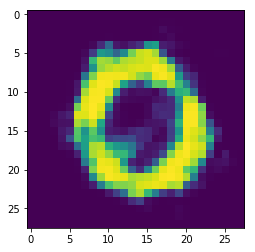

In [12]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,'./checkpoints/simple.ckpt')
    #print(data_distribution[0:5])
    #print(sess.run(output,{X:data_distribution,latent_samples:latent_distribution})[0:5])
    #print(sess.run(loss,{X:data_distribution,latent_samples:latent_distribution}))
    plt.imshow(sess.run(output,{X:train_x[1].reshape([-1,784]),latent_samples:latent_distribution[1].reshape([-1,16])})[0].reshape((28,28)))
    

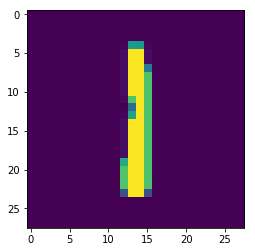

In [11]:
plt.imshow(train_x[2].reshape(28,28))

In [5]:
####################### MNIST MODEL ########################################
k = 9
mu_z, sigma_z = 0., 1.
latent_dist = np.random.normal(mu_z,sigma_z,(42000,7,7,32))
tf.Graph().as_default()
X = tf.placeholder(tf.float32, (None, 28, 28, 1))
with tf.name_scope('encoder'):
    en1 = tf.layers.Conv2D(64, (k,k))(X)
    en1 = tf.nn.leaky_relu(en1)
    en2 = tf.layers.Conv2D(64, (k,k), strides=(2,2))(en1)
    en2 = tf.nn.leaky_relu(en2)
    en3 = tf.layers.Conv2D(64, (3,3), strides=(1,1))(en2)
    en3 = tf.nn.leaky_relu(en3)
    en4 = tf.layers.Conv2D(64, (3,3), strides=(1,1))(en3)
    en4 = tf.nn.leaky_relu(en3)
    encoded = tf.layers.Conv2D(32, (3,3),padding='same',strides=(2,2))(en2)
    #encoded = tf.nn.leaky_relu(encoded)
batch_size = tf.shape(encoded)[0]
latent_samples = tf.placeholder(tf.float32,(None,7,7,32))
log_sigma = encoded[:,:,:,0:32]
mu = encoded[:,:,:,32:64]
Z = tf.exp(log_sigma) * latent_samples + mu 

with tf.name_scope('decoder'):
    de_3 = tf.layers.Dense(512)(Z)
    de_3 = tf.maximum(de_3, alpha*de_3)
    output = tf.layers.Dense(784,activation=tf.nn.sigmoid)(de_3)
'''
with tf.name_scope('decoder'):
    de1 = tf.layers.Conv2DTranspose(64,(3,3),padding='same',strides=(2,2))(Z)
    de1 = tf.nn.leaky_relu(de1)
    de2 = tf.layers.Conv2DTranspose(64,(7,7))(de1)
    de2 = tf.nn.leaky_relu(de2)
    de3 = tf.layers.Conv2DTranspose(64,(9,9))(de2)
    de3 = tf.nn.leaky_relu(de3)
    output = tf.layers.Conv2DTranspose(1,(3,3),padding='same',activation=tf.nn.sigmoid)(de3)
'''
beta = 1.3
squared_loss = tf.reduce_sum(tf.)#tf.reduce_sum(tf.square(X - output))
kl = beta * tf.reduce_sum(tf.square(tf.exp(log_sigma)) + tf.square(mu) - 1. - log_sigma)
mnist_train = tf.train.AdamOptimizer().minimize(squared_loss+kl)

In [6]:
epochs = 10
batch_s = 1
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess,'./checkpoints/simple.ckpt')
    try:
        for i in range(epochs):
            print('Epoch ' + str(i))
            for b in range(42000):
                sess.run(mnist_train,{X:train_x[b*batch_s:b*batch_s + batch_s],latent_samples:latent_dist[b*batch_s:b*batch_s + batch_s]})
                if b % 100 == 0:
                    saver.save(sess,'./checkpoints/mnist.ckpt')
                    print("Loss: " + str(sess.run(squared_loss,{X:train_x[b*batch_s:b*batch_s + batch_s],latent_samples:latent_dist[b*batch_s:b*batch_s + batch_s]})))
    except Exception as e:
        traceback.format_exc(e)
    finally:
        saver.save(sess,'./checkpoints/mnist.ckpt')
        print('Model saved')


Epoch 0
Loss: 125.301704
Loss: 87.7269
Loss: 110.86874
Loss: 84.88245
Loss: 46.786957
Loss: 221.25635
Loss: 80.600525
Loss: 47.646824
Loss: 80.658554
Loss: 133.14206
Loss: 38.80171
Loss: 68.400055
Loss: 119.239525
Loss: 75.19002
Loss: 80.298256
Loss: 46.840652
Loss: 89.259476
Loss: 85.79883
Loss: 108.181274
Loss: 110.957466
Loss: 137.32675
Loss: 100.30733
Loss: 52.80013
Loss: 33.30529
Loss: 90.97588
Loss: 66.37424
Loss: 105.6944
Loss: 25.201963
Loss: 52.026848
Loss: 115.495895
Loss: 85.96664
Loss: 92.94201
Loss: 34.9952
Loss: 131.6127
Loss: 31.889507
Loss: 93.80492
Loss: 132.92883
Loss: 120.321045
Loss: 50.53984
Loss: 56.542458
Loss: 121.10282
Loss: 72.479225
Loss: 79.92617
Loss: 105.00981
Loss: 74.58396
Loss: 87.32008
Loss: 87.19834
Loss: 69.84728
Loss: 86.359276
Loss: 160.2831
Loss: 62.92264
Loss: 124.19446
Loss: 101.26145
Loss: 64.333015
Loss: 73.89307
Loss: 42.36621
Loss: 87.12672
Loss: 109.871185
Loss: 116.77636
Loss: 95.64516
Loss: 34.949604
Loss: 88.78366
Loss: 106.774086
Loss: 

KeyboardInterrupt: 